Import the necessary libraries

In [1]:
import re
import pandas as pd
import joblib
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('data/selected.csv')

print(df['comments'].apply(lambda x: len(x.split(' '))).sum())

df.head(10)

110217


,username,comments,label
0,Different-Ad1735,"Hi,\n\nThis old tutorial does not work for me,...",Other
1,Most-Exit-5507,In high school I found a youtube channel calle...,Other
2,Frizzyawkward,I’m a soon to be veteran looking to get into v...,Other
3,OkTeaching4656,I currently work at Purdue animal hospital as ...,Other
4,Flashy-Ad-2261,"yes, i quit to. 0,013 myst a month is no good...",Other
5,ARatNamedClydeBarrow,"As a VA, this makes me so sad for you. Yeah it...",Vet
6,wachinayn,Thanks for the explanation. Do you think that ...,Other
7,TruggWalgChangs,This is *horrible* OPSEC lol ---> /r/Mysterium...,Other
8,kriki200,"Thanks, it just seems odd to me that they aren...",Other
9,FreshBread24,Thank you! It helps to know I’m not the only o...,Other


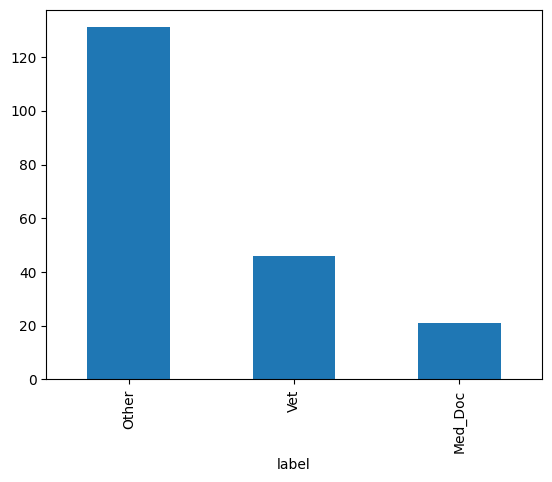

In [5]:
df.label.value_counts().plot(kind='bar');

In [6]:
df['label'].value_counts()

label
Other      131
Vet         46
Med_Doc     21
Name: count, dtype: int64

Dataset is imbalanced, other metrics apart from accuracy can be handy.

In [7]:

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /Users/honesty/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/honesty/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:

# Initialize stemmer
stemmer = PorterStemmer()

def combined_clean(comment):
    # Remove Non-ASCII characters
    comment = re.sub(r"\xa0", r" ", comment)
    comment = comment.encode("ascii", errors="ignore").decode()
    
    # Lower case the data
    comment = comment.lower()
    
    # Remove HTML Links
    comment = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', comment)
    comment = re.sub(r'\n', '', comment)
    
    # Removing special characters
    comment = re.sub(r"[^A-Za-z0-9!?\'\`]", " ", comment)

    # Removing all the numbers
    comment = re.sub(r'[0-9]+', ' ', comment)

    # Substituting multiple spaces with single space
    comment = re.sub(r'\s+', ' ', comment, flags=re.I)

    # Removing single letters
    comment = re.sub(r"\b[a-zA-Z]\b", "", comment)

    # Tokenizing
    tokens = word_tokenize(comment)
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming
    tokens = [stemmer.stem(token) for token in tokens]

    # Joining tokens back into a string
    cleaned_comment = ' '.join(tokens)

    return cleaned_comment

df['comments'] = df['comments'].apply(combined_clean)


In [9]:
# Total words in the data

df['comments'].apply(lambda x: len(x.split(' '))).sum()

59295

In [10]:
# feature and target

X = df['comments']
y = df['label'] 


In [11]:
# Splitting the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Encode the label

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [13]:
# Model training pipeline

models = [
    ("SGD Classifier", SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=13, tol=None)),
    ("Multinomial Naive Bayes", MultinomialNB()),
    ("Logistic Regression", LogisticRegression(n_jobs=1, C=1e5)),
    ("XGBoost Classifier", XGBClassifier(use_label_encoder=False,
                  max_depth=8, 
                  learning_rate=0.05, 
                  n_estimators=150, 
                  gamma=0.1, 
                  subsample=0.8, 
                  colsample_bytree=0.8, 
                  reg_alpha=0.1, 
                  reg_lambda=0.1
                  )),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest Classifier", RandomForestClassifier(n_estimators=100, random_state=42))
]

results = []
for name, model in models:
    pipe = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', model),
                    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    support = len(y_test)
    results.append([name, accuracy, precision, recall, f1, support])

metrics = pd.DataFrame(results, columns=['Machine Learning Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Support'])

metrics

,Machine Learning Model,Accuracy,Precision,Recall,F1 Score,Support
0,SGD Classifier,0.775,0.760000,0.775,0.757456,40
1,Multinomial Naive Bayes,0.675,0.455625,0.675,0.544030,40
2,Logistic Regression,0.825,0.842273,0.825,0.799167,40
3,XGBoost Classifier,0.700,0.655114,0.700,0.660985,40
4,Decision Tree,0.725,0.719464,0.725,0.721364,40
5,Random Forest Classifier,0.700,0.617308,0.700,0.595130,40


In [14]:
label_list = ['Med_Doc', 'Other', 'Vet']

In [15]:
lr = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=label_list))

accuracy 0.825
              precision    recall  f1-score   support

     Med_Doc       1.00      0.33      0.50         6
       Other       0.82      1.00      0.90        27
         Vet       0.80      0.57      0.67         7

    accuracy                           0.82        40
   macro avg       0.87      0.63      0.69        40
weighted avg       0.84      0.82      0.80        40



In [16]:
# Save the best model to disk

joblib.dump(lr, 'artifacts/logistic__model.pkl')

['artifacts/logistic__model.pkl']

In [18]:
all_data = pd.read_csv('data/comments.csv')

In [19]:
# Predict on test data

y_pred = lr.predict(all_data['comments'].apply(combined_clean))

In [20]:
# Inverse transform predicted labels

predicted_labels = le.inverse_transform(y_pred)

In [21]:
len(predicted_labels)

3276

In [22]:
# Create a new DataFrame to store the comments and predicted labels
predicted_df = all_data.copy()

In [23]:
len(predicted_df)

3276

In [24]:
# Add Predictions to DataFrame
predicted_df['label'] = predicted_labels

In [25]:
# Save the classified comments 

predicted_df.to_csv('result/classification_result.csv', index=False)